In [8]:
library(dplyr)
library(parallel)
library(stringr)

reprocess_switch=1 #0 or 1. 1 means to recreate all reach and node products following some change in processing. 
#0 means to just append to existing dataframes
process_PTs=1 # switch. do you want to deal with PTs and all downstream processing?
process_airborne =0 #swtich

# hubname='UNC'
# rivername='WK'
# continent='oc'
# PT_key_file= 'WK_Key_20230331.csv' #WK
# utm_zone='58 +south'#WK='58 +south'

# hubname='UMass'
# rivername='CR'
# continent='na'
# PT_key_file='SWOTCalVal_CR_Key_20230322_20230614.csv' #CT
# utm_zone=18 #Ct= 18

# hubname='CU'
# rivername='WM'
# continent='na'
# PT_key_file= 'SWOTCalVal_WM_KEY_20230326_20230510.csv' #WM
# utm_zone=10 #WM= 10

hubname='Brown'
rivername='NS'
continent='na'
PT_key_file= 'SWOTCalVal_NS_KEY_20230525_20230613.csv' #WM
utm_zone=13 #NS= 13


buffer=500 #m, 'extends' the reach

setwd(paste0('/nas/cee-water/cjgleason/calval/Processed data/',hubname,'/'))
domain_file=keyfile=paste0(rivername,'_domain.csv')
paste0('/nas/cee-water/cjgleason/calval/Processed data/',hubname,'/')

#PT paths---------
PT_data_directory=paste0('/nas/cee-water/cjgleason/calval/xml_scripts/',hubname,'/Munged/')
                        
flagged_PT_output_directory='Flagged PT/'
#--------------------------------------------------
#drift paths------------------------------------------
GNSS_drift_data_directory=paste0('From Andy/',hubname,'_netCDFs/')
if(reprocess_switch==1){
    
    drift_string= paste0('Munged drifts/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'))
    PT_string =paste0('Munged PT/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'))
    reachnode_string= paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'))
    node_string =paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'),'/node')
    reach_string=paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'),'/reach')
    
    #check if we've already reprocessed today
    if (dir.exists(drift_string)){
        #if we have, then use that as the output and clear the files in the drift directory
        unlink(drift_string, recursive = TRUE)
        unlink(PT_string,recursive = TRUE)
        dir.create(drift_string)
        dir.create(PT_string)
        QA_QC_drift_output_directory=paste0(drift_string,'/')
        QA_QC_PT_output_directory=paste0(PT_string,'/')
        reachnode_output_directory=paste0(reachnode_string,'/')
        } else {
        #if we haven't reprocessed today
        
        
    dir.create(drift_string)
    dir.create(PT_string)
    dir.create(reachnode_string)
    dir.create(node_string)
    dir.create(reach_string)
        
    QA_QC_drift_output_directory=paste0(drift_string,'/')
    reachnode_output_directory=paste0(reachnode_string,'/')
    QA_QC_PT_output_directory=paste0(PT_string,'/')
    }
    
    } else { #we aren't reprocessing. find the most recent folders to use
    
folderlist= list.files('Munged drifts',full.names = TRUE)
    
foldertimes=file.info(folderlist)%>%
 mutate(mintime= Sys.time()-mtime) %>%
 filter(mintime== min(mintime)) 
    
QA_QC_drift_output_directory=paste0(row.names(foldertimes),'/')  
    
folderlist2= list.files('Data frames',full.names = TRUE)
    
foldertimes2=file.info(folderlist2)%>%
 mutate(mintime= Sys.time()-mtime) %>%
 filter(mintime== min(mintime)) 
    
reachnode_output_directory=paste0(row.names(foldertimes2),'/')
    
folderlist3= list.files('Munged PT',full.names = TRUE)
    
foldertimes3=file.info(folderlist3)%>%
 mutate(mintime= Sys.time()-mtime) %>%
 filter(mintime== min(mintime))  
    
QA_QC_PT_output_directory=paste0(row.names(foldertimes3),'/') 
}

flagged_drift_output_directory='Flagged drifts/'
#--------------------------------------------------

#sword paths----------------------------------------
SWORD_path=paste0('/nas/cee-water/cjgleason/calval/SWORD_15/netcdf/',continent,
                  '_sword_v15.nc')
#------------------------------



[1] "/nas/cee-water/cjgleason/calval/Processed data/Brown/"

In [16]:
QA_QC_drift_output_directory
QA_QC_PT_output_directory
reachnode_output_directory
flagged_PT_output_directory


[1] "Munged drifts/reprocessed_2023_06_30/"

[1] "Munged PT/reprocessed_2023_06_30/"

[1] "Data frames/reprocessed_2023_06_30/"

[1] "Flagged PT/"

In [3]:
# stopCluster(cl)

In [10]:
#create dataframes from drifts---------------------------------------------------------
#pull filename before the .csv
source('/nas/cee-water/cjgleason/calval_toolbox/R code/create_GNSS_dataframe.R')
raw_GNSS=sub( "\\..*","", list.files(GNSS_drift_data_directory,recursive=TRUE))
raw_GNSS_river=which(!is.na(do.call(rbind,lapply(raw_GNSS,str_match,rivername))))
raw_GNSS=raw_GNSS[raw_GNSS_river]

#pull filename before the second _
QA_QC_drifts=sub( "\\..*","",list.files(QA_QC_drift_output_directory))
flagged_drifts=sub("\\..*","",list.files(flagged_drift_output_directory))
#what raw drift data have not been munged
unmunged_drifts=setdiff(raw_GNSS,c(flagged_drifts,QA_QC_drifts))


# create_gnss_dataframe(unmunged_drifts[1],
#                   gnss_drift_data_directory=GNSS_drift_data_directory,
#                   output_directory=QA_QC_drift_output_directory)

# for (i in 1:10){
# create_gnss_dataframe(unmunged_drifts[i],
#                   gnss_drift_data_directory=GNSS_drift_data_directory,
#                   output_directory=QA_QC_drift_output_directory)}
# if(!identical(unmunged_drifts,character(0))){

    cl=makeCluster(44)

    
  dummy=parLapply(cl=cl,unmunged_drifts,create_gnss_dataframe,
                  gnss_drift_data_directory=GNSS_drift_data_directory,
                  output_directory=QA_QC_drift_output_directory)
  stopCluster(cl)


#-------------------------------------------------

In [40]:
#munge PTs if needed------
if (process_PTs==1){
dist_thresh=150 # 150m
time_thresh= 15*60 #minutes as seconds, centered, so 15 =30 mins total time
GNSS_sd_thresh=0.15 # 15cm how much variance do you want in the GNSS data when it is within the distance threshold?
offset_sd_thresh=0.10 #m, so 10cm. the the PT apparantly shift by more than a cm?
change_thresh_15_min=0.05#m- does it change more than 5cm in 15 minutes? that is a discontinuity in offset

#check for un-munged PT data
#first, move .csv files with an 'L1' in them over to the PT_data_directory
munged_files= list.files(PT_data_directory,
                         recursive= TRUE)

PT_index=which(!is.na(do.call(rbind,lapply(munged_files,str_match,'PT_L1'))))
PT_files=munged_files[PT_index]
csv_index=which(!is.na(do.call(rbind,lapply(PT_files,str_match,'.csv'))))
csv_PT_files=PT_files[csv_index]

#pull filename before the .csv
raw_PT=sub("\\..*","",csv_PT_files)
raw_PT=sub(".*/","",raw_PT)
#pull filenam\\..*e before the second _
QA_QC_PTs=sub("\\..*","",list.files(QA_QC_PT_output_directory))
flagged_PTs=sub( "\\..*","",list.files(flagged_PT_output_directory))
#what raw PT data have not been munged
    #need to preserve the full path in csv_PT_files!
unmunged_PTs=setdiff(csv_PT_files,c(flagged_PTs,QA_QC_PTs))
    
    
#run the PTs that are not yet munged
    
    #print(unmunged_PTs)
options(warn=-1)
files_to_run=list()
 for (i in 1:length(unmunged_PTs)){
files_to_run[[i]]=munged_files[which(!is.na(str_match(munged_files,unmunged_PTs[i])))]
     }

 files_to_run=paste0('/nas/cee-water/cjgleason/calval/xml_scripts/',hubname,'/Munged/',files_to_run)

if(!identical(unmunged_PTs,character(0))){
  source('/nas/cee-water/cjgleason/calval_toolbox/R code/correct_PT_to_GNSS.R')
    

    klugeit=function(filename){
        output=as.integer(read.table(paste0(PT_data_directory,filename),header = FALSE, nrow = 1)$V1)
     
        }
    
pt_serial= data.frame(id=do.call(rbind,lapply(unmunged_PTs,klugeit)))


    good_index=which(!is.na(pt_serial))
    
unmunged_PTs=unmunged_PTs[good_index]
    
    
# correct_pt_to_gnss(unmunged_PTs[1],
#                   pt_key_file=PT_key_file,
#                   dist_thresh=dist_thresh,
#                   time_thresh=time_thresh,
#                   pt_data_directory=PT_data_directory,
#                   gnss_drift_data_directory=QA_QC_drift_output_directory,
#                   QA_QC_pt_output_directory=QA_QC_PT_output_directory,
#                   flagged_pt_output_directory=flagged_PT_output_directory,
#                   gnss_sd_thresh=GNSS_sd_thresh,
#                   offset_sd_thresh=offset_sd_thresh,
#                   change_thresh_15_min=change_thresh_15_min)
    
    
      cl=makeCluster(44)
  
  dummy=parLapply(cl, unmunged_PTs,correct_pt_to_gnss,
                  pt_key_file=PT_key_file,
                  dist_thresh=dist_thresh,
                  time_thresh=time_thresh,
                  pt_data_directory=PT_data_directory,
                  gnss_drift_data_directory=QA_QC_drift_output_directory,
                  QA_QC_pt_output_directory=QA_QC_PT_output_directory,
                  flagged_pt_output_directory=flagged_PT_output_directory,
                  gnss_sd_thresh=GNSS_sd_thresh,
                  offset_sd_thresh=offset_sd_thresh,
                  change_thresh_15_min=change_thresh_15_min)
  
  stopCluster(cl)

    
   
}

}

#-----------------------------


Linking to GEOS 3.11.1, GDAL 3.6.2, PROJ 9.1.0; sf_use_s2() is TRUE

Loading required package: sp

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-32, (SVN revision 1176)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.6.2, released 2023/01/02
Path to GDAL shared files: /home/cjgleason_umass_edu/.conda/envs/supposedlybetter/share/gdal
 GDAL does not use iconv for recoding strings.
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 9.1.0, September 1st, 2022, [PJ_VERSION: 910]
Path to PROJ shared files: /home/cjgleason_umass_edu/.local/share/proj:/home/cjgleason_umass_edu/.conda/envs/supposedlybetter/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.5-1
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or

[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am return

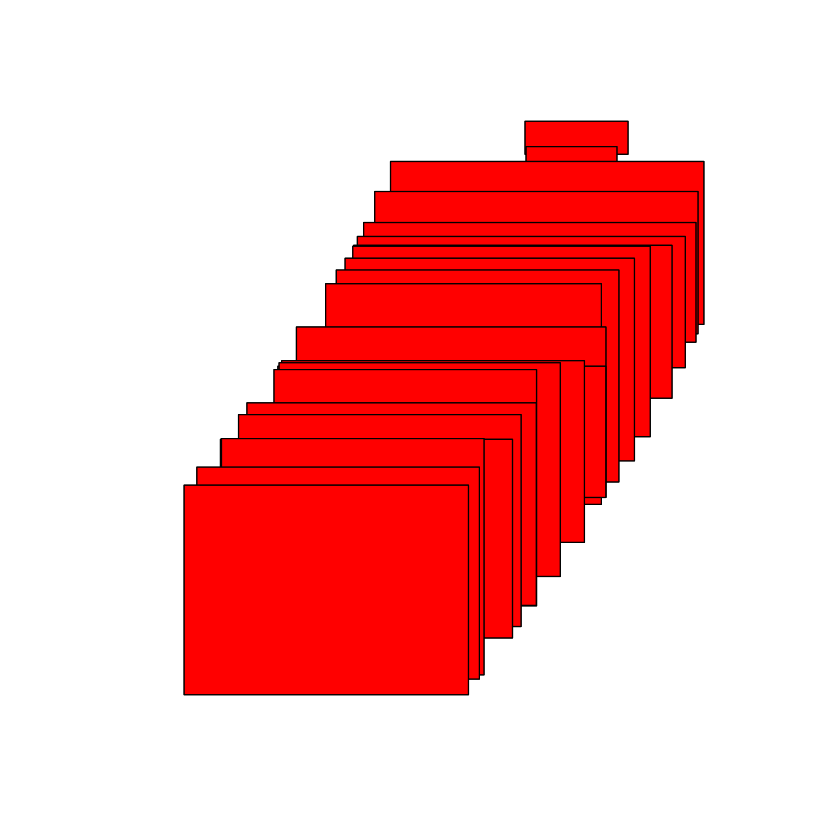

In [41]:
#calculate slopes and heights from drifts within nodes and reaches------

SWORD_reach= read.csv(domain_file)
this_river_reach_IDs= as.numeric(unique(SWORD_reach$Reach_ID[!is.na(SWORD_reach$Reach_ID)]))
this_river_node_IDs= as.numeric(unique(SWORD_reach$Node_ID[!is.na(SWORD_reach$Node_ID)]))


options(warn=-1)
source('/nas/cee-water/cjgleason/calval_toolbox/R code/calculate_slope_wse_fromdrift.R')

dummy=calculate_slope_wse_fromdrift(SWORD_path=SWORD_path,
                                    drift_directory=QA_QC_drift_output_directory,
                                    PT_directory=PT_directory,
                                    output_directory=reachnode_output_directory,
                                    this_river_reach_ids=this_river_reach_IDs,
                                    this_river_node_ids=this_river_node_IDs,
                                    utm_zone=utm_zone, 
                                    buffer=buffer,
                                    rivername=rivername,
                                    reprocess_switch=reprocess_switch)

# dummy
#-----------------------------

In [44]:
#calculate slopes and heights from PTs within nodes and reaches----
if (process_PTs==1){
PT_files=paste0(QA_QC_PT_output_directory,list.files(QA_QC_PT_output_directory))
SWORD_reach= read.csv(domain_file)
this_river_reach_IDs= as.numeric(as.character(unique(SWORD_reach$Reach_ID)))


alongstream_error= 0.0001*200 #m error we get from the downstream slope of a reach in a node. This placeholder is a 1e-4 slope over a 200m node
crossstream_error= 0.005 #m error we get from PT not representing cross stream superelevation/noise in a node
measurement_error= 0.001 #m error we get from PT measurement itself 
source('/nas/cee-water/cjgleason/calval_toolbox/R code/calculate_slope_wse_fromPT.R')


dummy=calculate_slope_wse_fromPT(keyfile=PT_key_file,
                                 pt_files=PT_files,
                                 SWORD_path=SWORD_path,
                                 SWORD_reach=SWORD_reach,
                                 this_river_reach_ids=this_river_reach_IDs,
                                 rivername=rivername,
                                 output_directory= reachnode_output_directory,
                                 alongstream_error=alongstream_error,
                                 crossstream_error=crossstream_error,
                                 measurement_error=measurement_error)
     }
#-----------------------------

[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am return

`summarise()` has grouped output by 'node_id'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'reach_id'. You can override using the
`.groups` argument.


In [45]:
#define what drift goes with what SWOT overpass--------------------
#SWOT_L2_HR_RiverSP_<FileIdentifier>_<CycleID>_<PassID>_<ContinentID>_<RangeBeginningDateTime>_<RangeEndingDateTime>_<CRID>_<ProductCounter>.<extension> 
if (process_PTs==1){
passfile='/nas/cee-water/cjgleason/calval/Processed data/riversp_list_clean_20230628.txt'

 
passnames=read.delim(passfile,header=F,fileEncoding = 'UTF-16LE')$V1[which(!is.na(str_match(read.delim(passfile,header=F,fileEncoding = 'UTF-16LE')$V1,'NA')))]

  
time_threshold_sec= 120*60 #two hour
wse_threshold_m=0.05 #within 5cm
distance_threshold_m =200 #within 200m

if (!dir.exists(paste0('Matched_drifts/','processed_',str_replace_all(as.character(Sys.Date()),'\\-','_')))){
    dir.create(paste0('Matched_drifts/','processed_',str_replace_all(as.character(Sys.Date()),'\\-','_')))}


matched_output_directory= paste0('Matched_drifts/','processed_',str_replace_all(as.character(Sys.Date()),'\\-','_'),'/')
munged_drift_directory= QA_QC_drift_output_directory
munged_pt_directory=QA_QC_PT_output_directory

source('/nas/cee-water/cjgleason/calval_toolbox/R code/select_appropriate_drift.R')

   select_appropriate_drift(passnames[1],
                               drift_node_directory= paste0(reachnode_output_directory,'/node/'),
                               munged_drift_directory=munged_drift_directory,
                               matched_output_directory=matched_output_directory,
                               munged_pt_directory=munged_pt_directory,
                               time_threshold_sec=time_threshold_sec,
                               wse_threshold_m= wse_threshold_m,
                               distance_threshold_m=distance_threshold_m,
                               keyfile=PT_key_file,
                               rivername=rivername)

  
#   cl=makeCluster(44)
# dummy=parLapply(cl, passnames,select_appropriate_drift,
#                                drift_node_directory= paste0(reachnode_output_directory,'/node/'),
#                                munged_drift_directory=munged_drift_directory,
#                                matched_output_directory=matched_output_directory,
#                                munged_pt_directory=munged_pt_directory,
#                                time_threshold_sec=time_threshold_sec,
#                                wse_threshold_m= wse_threshold_m,
#                                distance_threshold_m=distance_threshold_m,
#                                keyfile=PT_key_file,
#                                rivername=rivername)

# stopCluster(cl)
    }
#-----------------------------

ERROR: Error in checkForRemoteErrors(val): 44 nodes produced errors; first error: cannot open the connection


In [ ]:
#calcluate areas from images------------------
if (process_airborne ==1){

a=Sys.time()

library(parallel)
source('/nas/cee-water/cjgleason/calval_toolbox/R code/calculate_area_from_imagery.R')

scale_maxwidth = 3
#path of input image 
#image = '/nas/cee-water/cjgleason/calval/Processed data/Imagery/Input/BinaryMap.tif'

    imagelist=list.files(image_directory)
    
#output dir
dir_output = '/nas/cee-water/cjgleason/calval/Processed data/Imagery/Output/'


# calculate_area_from_imagery(image=image,
#                  this_river_reach_ids=image_reaches,
#                  this_river_node_ids=image_nodes,
#                  rivercode=rivername,
#                  utm_zone=utm_zone,
#                  scale_maxwidth=scale_maxwidth, 
#                  SWORD_path=SWORD_path)

cl=makeCluster(44)

dummy=parLapply(cl, calculate_area_from_imagery, imagelist,
                      this_river_reach_ids=image_reaches,
                 this_river_node_ids=image_nodes,
                 rivercode=rivername,
                 utm_zone=utm_zone,
                 scale_maxwidth=scale_maxwidth, 
                 SWORD_path=SWORD_path)

stopCluster(cl)
    
print(Sys.time()-a)#calcluate areas from images----

}
